In [16]:
import pandas as pd
import pickle
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix

## Modelling

With data cleaning, exploration, and pre-processing completed, we are now ready to begin training flight delay prediction models to guide the BTS's future data collection.

We will begin by bringing in our data.

In [5]:
# Importing in pre-processed data
y_train = pd.read_pickle('./data/y_train')
y_test = pd.read_pickle('./data/y_test')
with open('./data/X_train_sparse.pickle', 'rb') as X_train_pickle_file:
    X_train_sparse = pickle.load(X_train_pickle_file)
with open('./data/X_test_sparse.pickle', 'rb') as X_test_pickle_file:
    X_test_sparse = pickle.load(X_test_pickle_file)
with open('./data/X_train_columns.pickle', 'rb') as train_columns_pickle_file:
    X_train_columns = pickle.load(train_columns_pickle_file)
with open('./data/X_test_columns.pickle', 'rb') as test_columns_pickle_file:
    X_test_columns = pickle.load(test_columns_pickle_file)

Before we continue, a word of caution to anyone attempting to follow along with this code:

Due to the sheer scale of our dataset, it is not advisable to run the remainder of this notebook's modelling code on an individual device as it is nearly guaranteed to fail due to insufficient memory.

The following code cell, while theoretically optional, is highly recommended for all but the most cutting-edge computers that attempt to follow this modelling process. This cell will use random sampling to extract a representative subset of the data that is small enough to be run on an individual machine.

In [7]:
# Extracting a representative sample from the dataset
training_set_samples = np.random.choice(X_train_sparse.shape[0], X_train_sparse.shape[0]//100, replace=False)
X_train_sparse = X_train_sparse[training_set_samples, :]
y_train = y_train.reset_index().drop('index',axis=1).loc[training_set_samples.tolist()]['ArrDel15']

When evaluating the performance of the models we will be making, it is important to know ahead of time what accuracy we would consider to be good for our dataset.

For any given dataset and model type, there is a baseline of model effectiveness that must be exceeded in order for a model to be said to have learned anything at all. For predictive classifer models, this baseline is the 'majority class classifier', which is a model that simply predicts the most common class in a dataset every time.

If a dataset is largely composed of a single class of data, then it is not enough for our model to exceed 50% accuracy. It must exceed the accuracy of the majority class classifier instead. The following cell displays the proportion of each class in our dataset, from which we can determine the baseline.

In [8]:
# Displaying the baseline classifier accuracy
y_train.value_counts(normalize=True)

0.0    0.795239
1.0    0.204761
Name: ArrDel15, dtype: float64

As we can see, the `0` class which corresponds to non-delayed flights are the vast majority of our dataset and make up 79.5% of our rows. As such, the baseline accuracy that our models must significantly exceed in order to be considered meaningful is 79.5%.

With the baseline thus established, we can move on to selecting our models.

When selecting a model to train, it is important to keep in mind what we need our model to do. While popular models such as Gradient Boosting and Neural Networks can all boast high predictive power, they do so at the cost of interpretability. Such models can rarely explain the reasoning behind their decisions accurately, especially when given sparse data like our own.

Given that the purpose of our delay model is to guide the BTS' data collection efforts for future models, it is important to ensure that any model we train is interpretable enough for us to determine which columns of data were most important to its predictions.

### Logistic Regression

Logistic Regression is a simple classifier model that employs the principles of linear regression to apply a single numeric weight to each column in our dataset that it uses to predict the odds of a flight being delayed. Of all the models available to us, this one is both the simplest and the most interpretable. If the model performs well, then it will allow us to see, in quantifiable terms, the affect that a feature has on our model's decision to classify a flight. And when given binary target data in particular, as is the case in our delay data, Logistic Regression can communicate which class a particular feature is associated with through the sign of its numeric weight.

The following cell trains several Logistic Regression models with varying parameters and selects the one with the best testing accuracy.

In [9]:
# Defining logistic regression parameters to sweep over
logreg_params = {
    'penalty':['l1','l2'],
    'C':[0.1,1,10]
}
# GridSearching logistic regression classifiers
logreg_grid = GridSearchCV(LogisticRegression(solver='liblinear'), logreg_params, n_jobs=-2)
logreg_grid.fit(X_train_sparse, y_train)
# Printing out train and test accuracy scores
print(f'Training accuracy: {logreg_grid.score(X_train_sparse, y_train)}')
print(f'Testing accuracy: {logreg_grid.score(X_test_sparse, y_test)}')

Training accuracy: 0.8248253955325691
Testing accuracy: 0.8225120124907913


Looking at the above testing accuracy, we can see a suspiciously low performance from this model. Compared to the baseline of 79%, this model's 82% accuracy is a nearly negligible improvement.

Looking at a confusion matrix of the model's results can help us better understand the nature of our model's inaccuracy.

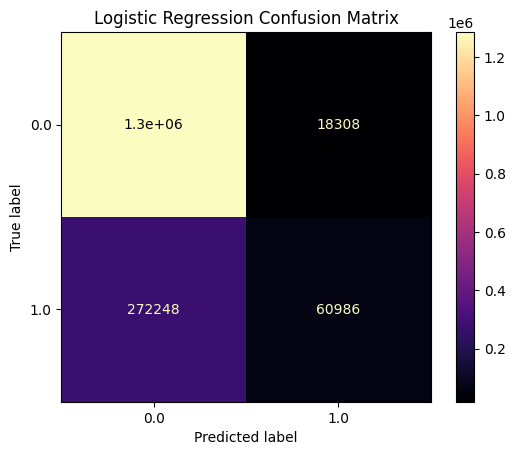

In [19]:
ConfusionMatrixDisplay.from_estimator(logreg_grid, X_test_sparse, y_test, cmap='magma');
plt.title('Logistic Regression Confusion Matrix');

Here we can see that the model is extraordinarily biased towards predicting the majority class. The vast majority of the incorrect predictions are from the model predicting no delay for delayed flights, rather than the inverse. This coupled with the extremely low performance suggests that the model is not learning any relationships between the dataset and flight delay status.

### Random Forest

Random Forest is a model based on the large scale use of decision trees. Decision trees are flexible and powerful models that seek to make incremental splits on a dataset's features in order to assign classifications based on where a given entry falls at the end of the tree. Decision trees are well known for grossly overfitting to their datasets in a way that can greatly reduce their effectiveness. Random Forest mitigates this issue by training a large number of trees on smaller amounts of data and making predictions based on a consensus or average result across all decision trees.

Compared to Logistic Regression, Random Forest has less interpretability since it can provide a quantifiable importance for each column (through metrics such as Gini Impurity or Entropy) but cannot indicate which of the two classes (delayed or not delayed) a column is more closely associated with. Despite this, Random Forest's ability to capture complex patterns in a dataset gives it the potential to achieve a higher accuracy than Logistic Regression. If its accuracy ends up being significantly higher, we would be wise to select it over the more interpretable Logistic Regression, as any inferences drawn from an inaccurate model is not guaranteed to be accurate to our dataset.

The following cell trains and scores an optimized Random Forest classifier by training several models with different parameters and selecting the one with the best performance.

In [10]:
# Defining random forest parameters to sweep over
rfc_params = {
    'n_estimators':[100,1000],
    'max_depth':[100,1000],
    'ccp_alpha':[0, 0.1]
}
# GridSearching random forest classifiers
rfc_grid = GridSearchCV(RandomForestClassifier(), rfc_params, n_jobs=-2)
rfc_grid.fit(X_train_sparse, y_train)
# Displaying train and test scores
print(f'Training accuracy: {rfc_grid.score(X_train_sparse, y_train)}')
print(f'Testing accuracy: {rfc_grid.score(X_test_sparse, y_test)}')

Training accuracy: 0.7952393557451487
Testing accuracy: 0.7964418837344828


Looking at the above testing accuracy, we can see an even more suspiciously low performance from this model. Compared to the baseline of 79%, this model's 79% accuracy shows no improvement whatsoever. Given the fact that the testing data contains a slightly different distribution of data than the training data, it is possible that this model is simply acting as a majority class classifier. To investigate this possibility, we can look at the model's confusion matrix.

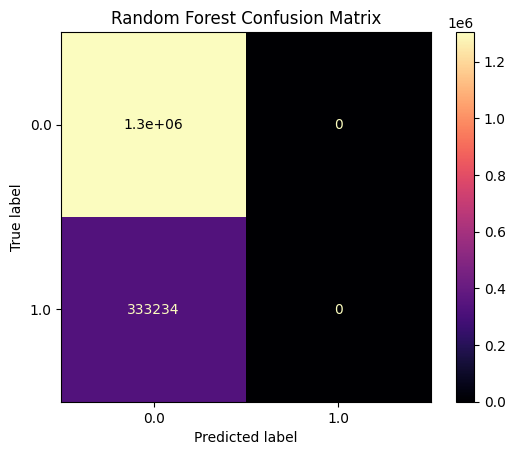

In [20]:
ConfusionMatrixDisplay.from_estimator(rfc_grid, X_test_sparse, y_test, cmap='magma');
plt.title('Random Forest Confusion Matrix');

Looking at the above matrix, we can see that our Random Forest model is functionally identical to a majority class classifier, as it simply predicts that every flight is not delayed. Given the scale of our dataset and the predictive power of Random Forest models in general, this performance raises the possibility that the problem lies not in our model, but in the data itself.

To confirm this suspicion, we can train one final model on our data.

### AdaBoost

Like Random Forest, AdaBoost is a model that makes use of a large number of decision trees. Rather than training multiple full-size decision trees on portions of data, AdaBoost opts to train multiple shallow decision trees on the entire dataset. Every time a shallow tree is trained in AdaBoost, the model checks which data points the new tree failed to correctly predict and assigns extra importance to those entries when training the next shallow tree. Through the use of shallow trees, AdaBoost avoids the issue of overfitting that plagues tree-based models while retaining predictive power through its training method. And as a tree-based model, AdaBoost retains the ability to provide feature importance metrics in the same way as Random Forest.

However, the same training method that allows AdaBoost to perform so well also introduces a unique set of flaws that limit its utility. Since the model relies so heavily on changing the importance of data points in its training data, AdaBoost is particularly sensitive to the quality and size of its dataset. If not given sufficient data or if given noisy data, AdaBoost can fail to produce adequate results. Given the extreme scale of our dataset, we can expect AdaBoost to find learn all the connections between our dataset and flight delays... if they exist.

The following cell trains and scores an optimized AdaBoost classifier by training several models with different parameters and selecting the one with the best performance.

In [11]:
# Defining AdaBoost parameters to sweep over
abc_params = {
    'n_estimators':[100,200,500],
    'learning_rate':[0.5,1,1.5]
}
# GridSearching AdaBoost classifiers
abc_grid = GridSearchCV(AdaBoostClassifier(), abc_params, n_jobs=-2)
abc_grid.fit(X_train_sparse, y_train)
# Displaying train and test scores
print(f'Training accuracy: {abc_grid.score(X_train_sparse, y_train)}')
print(f'Testing accuracy: {abc_grid.score(X_test_sparse, y_test)}')

Training accuracy: 0.8216692797947507
Testing accuracy: 0.8168457086728168


And once again, we see that our fine-tuned model has shown suspiciously poor results. This model's testing accuracy of 81% is a negligible improvement on the baseline of 79% despite the wealth of data and the complexity of the optimized model provides yet more evidence to the idea there is a flaw in our model's training data.

We can look at this model's confusion matrix to further confirm its behavior.

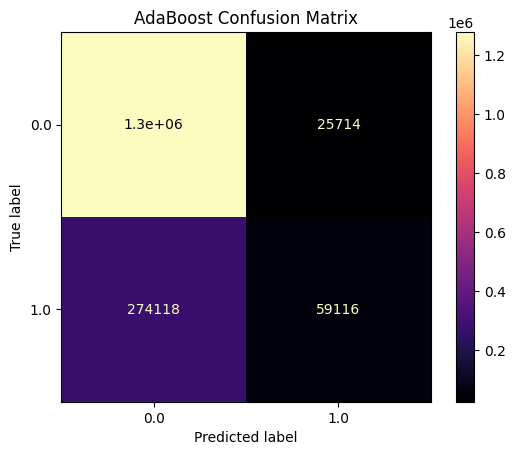

In [22]:
ConfusionMatrixDisplay.from_estimator(abc_grid, X_test_sparse, y_test, cmap='magma');
plt.title('AdaBoost Confusion Matrix');

As with the Logistic Regression and Random Forest models, we can see that the model is struggling to identify any pattern that it can use to determine if a flight is delayed. As such, the model defaults to predicting no delay in the majority of cases, even when a flight was truly delayed.

When taking the results of these three models into consideration, we can begin to draw our conclusions as to why these powerful model have performed so poorly, and what the BTS should do to improve future flight delay modelling efforts.

## Conclusions

In many cases, models fail to achieve a high level of performance due to insufficient data, insufficient complexity, or excessive complexity. Without enough data to pull from, no model can learn the underlying trends that connect a dataset to its target variable. Similarly, models that are too simple often fail to capture the complexities of real-world patterns and thus fail to find meaningful connections they can use to make predictions while models that ar etoo complex overfit to their data, choosing to memorize it rather than learn from it.

However, none of these issues are likely to be the cause of our models' poor predictive performance. The BTS' dataset is a truly gargantuan collection with billions of data points. Even when restricted to a single year's worth of data, there are millions of rows to pull from when training our model. Given the relative simpliicity of binary classification, it is unlikly that our models lack sufficient data to learn the relationship between the BTS' information and flight delays.

Similarly, our models' results are unlikely to be the result of insufficient or excessive complexity complexity. Both Random Forest and AdaBoost are tree-based models infamous for their potential to balloon in complexity and overfit to their datasets. However, the training accuracy of our models shows equally poor performance to their testing accuracies. In overfit models, training accuracy would far exceed testing accuracy, indicating that the model has attempted to perfectly conform to its tarining data and thus missed the broader patterns it was expected to find in the testing data. The fact that we do not see this indicates that our model's performance cannot be the result of excessive complexity.

From this, we can derive one major insight that the BTS can use to guide the improvement of its data collection. And that is the fact that __there is no meaningful connection between the BTS's data columns and flight delays__.

When training machine learning models, there is always an implicit requirement that the data provided bear some causal or correlated connection to the target that the model is attempting to predict. No one would expect to able to train a model of city traffic on a dataset of movie ratings. If our models are being given ample clean data, are complex enough to capture even the most intricate of relationships, and are not overfitting to their training set, then we can only conclude that the dataset is largely unrelated to the target.

In the case of flight delay prediction, this conclusion is not without precedent.

The majority of academic papers into the causes of flight delays center on one of three major causes: The maintenance and upkeep of the plane and airport, the amount of and rate of change in supply and demand for air travel, and the weather conditions along the flight's route.

Planes or airports that have gone without maintenance for an extended period of time are more likely to experience technical difficulties that delay takeoff. A sudden and unexpected increase in demand for flights can leave airports unable to send out flights on time as they struggle to deal with the fact that a majority of flight are overbooked under the assumption that some passengers will not arrive. And extreme weather conditions can hold back a flight's takeoff, postpone its landing, or change its flight path in ways that delay its arrival.

Despite the importance of these factors, __the BTS' dataset does not include any of these factors in its database of flight delay statistics, not even weather.__

Taking all this into consideration, we can conclude that the BTS should prioritize adding new data such as the date of a plane or origin airport's most recent maintenance, The ratio of traveller to active flights for the given time period, and the anticipated weather conditions during takeoff to its dataset. Doing this would allow future models to incorporate new data that may be more strongly correlated with flight delay and address the dataset's current lack of connection to the very thing its seeking to monitor.